In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


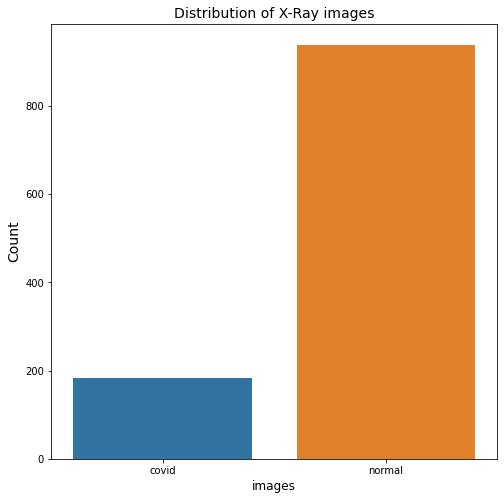

(1122, 272, 272, 3)
(1122, 1)
(481, 272, 272, 3)
(481, 1)
Number of class:2


In [3]:
import sys
sys.path.insert(0,'drive/data_NPZ')

import os 
import glob
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

def load_data_training_and_test(path):
    npzfile = np.load(path + "2class_forCan_all_training_data.npz")
    train = npzfile['arr_0']
    
    npzfile = np.load(path + "2class_forCan_all_training_label.npz")
    train_labels = npzfile['arr_0']
    
    train_set, test_set = train_test_split(train,test_size=0.3,random_state=0)
    train_label,test_label=train_test_split(train_labels,test_size=0.3,random_state=0)

    return (train_set,train_label),(test_set,test_label)


path='drive/data_NPZ/can-net/'

(x_train, y_train), (x_test, y_test) = load_data_training_and_test(path)



df = pd.DataFrame(data=y_train, columns=["status"])

import seaborn as sns

fig, ax = plt.subplots(figsize=(8,8))
sns.countplot('status',data=df)
ax.set_title('Distribution of X-Ray images', fontsize=14)
ax.set_xlabel('images', fontsize=12)
ax.set_ylabel('Count', fontsize=14)
plt.show()


y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

# Change our image type to float32 data type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)




from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_test = mlb.fit_transform(y_test)

mlb2=MultiLabelBinarizer()
y_train=mlb2.fit_transform(y_train)

num_classes = y_test.shape[1]
print("Number of class:"+str(num_classes))


#    rescale=1./255,
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    shear_range=0.2,
    rotation_range=5,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rotation_range=5
 )

datagen.fit(x_train)
test_datagen.fit(x_test)



In [4]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,LeakyReLU
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization


#n_filters

input_shape = (272, 272, 3)

def get_netork():
      model = Sequential()

      #1st katman

      model.add(Conv2D(32,(4,4),input_shape=input_shape,strides=(2,2)))

      model.add(BatchNormalization())
      model.add(LeakyReLU())
      
      model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding='valid'))


      # 2nd katman
      model.add(Conv2D(16,(4,4),strides=(2,2)))

      model.add(BatchNormalization())
      model.add(LeakyReLU())

      model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))

      #Triple Conv block
      model.add(Conv2D(32,(2,2),strides=(1,1)))

      model.add(BatchNormalization())
      model.add(LeakyReLU())

      model.add(Conv2D(32,(1,1),strides=(1,1)))

      model.add(BatchNormalization())
      model.add(LeakyReLU())

      model.add(Conv2D(32,(1,1),strides=(1,1)))

      model.add(BatchNormalization())
      model.add(LeakyReLU())

      model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))


            #↨ Fully connencted Layer

      model.add(Flatten())


      model.add(Dense(1024))
      model.add(Activation("relu"))#kernel_initializer='random_normal'
      model.add(Dropout(0.4))

      model.add(Dense(1024))
      model.add(Activation("relu"))#kernel_initializer='random_normal'
      model.add(Dropout(0.4))


      model.add(Dense(num_classes))#kernel_initializer='random_normal'
      model.add(Activation("softmax"))

      #model.summary()

      return model

Epoch 1/20
18/18 [==============================] - 27s 1s/step - loss: 2.4601 - accuracy: 0.8155 - val_loss: 0.0000e+00 - val_accuracy: 0.8358

Epoch 00001: val_accuracy improved from -inf to 0.83576, saving model to drive/best_weights_for_CanNet_2class.hdf5
Epoch 2/20
18/18 [==============================] - 23s 1s/step - loss: 2.5023 - accuracy: 0.8369 - val_loss: 0.0000e+00 - val_accuracy: 0.8358

Epoch 00002: val_accuracy did not improve from 0.83576
Epoch 3/20
18/18 [==============================] - 23s 1s/step - loss: 2.5134 - accuracy: 0.8369 - val_loss: 0.0000e+00 - val_accuracy: 0.8358

Epoch 00003: val_accuracy did not improve from 0.83576
Epoch 4/20
18/18 [==============================] - 23s 1s/step - loss: 2.5246 - accuracy: 0.8369 - val_loss: 0.0000e+00 - val_accuracy: 0.8358

Epoch 00004: val_accuracy did not improve from 0.83576
Epoch 5/20
18/18 [==============================] - 24s 1s/step - loss: 2.5134 - accuracy: 0.8369 - val_loss: 15.3371 - val_accuracy: 0.8358

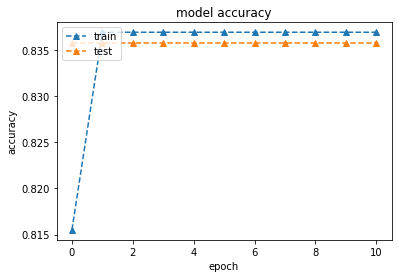

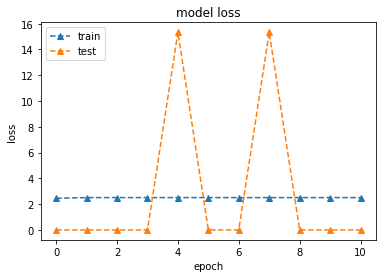

In [15]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from keras.optimizers import SGD,Adam,RMSprop,Adadelta,Adagrad,Adamax
opt = Adamax()

#opt = Adam(lr= 0.001,decay=1e-6)
#opt=keras.optimizers.rmsprop(lr=1,decay=1e-6)
#opt=keras.optimizers.adam(lr=1)


model=get_netork()
model.compile(loss='binary_crossentropy', #2 class
              optimizer=opt,
              metrics=['accuracy'])

#print(model.summary())


early_stop=EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=0, mode='auto')

#print(model.summary())



weight_name="drive/best_weights_for_CanNet_2class.hdf5"
checkpointer = ModelCheckpoint(filepath=weight_name, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)


history=model.fit_generator(datagen.flow(x_train,y_train,batch_size=64),callbacks=[checkpointer,early_stop],validation_data = test_datagen.flow(x_test,y_test)
                            ,epochs=20)

"""
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)"""

model.save("drive/CanNet_2classwith_AUG.h5")

print("\n")

import matplotlib.pyplot as plt
# Plot Accuracy
print(history.history.keys())
plt.plot(history.history['accuracy'],'^--')
plt.plot(history.history['val_accuracy'],'^--')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'],'^--')
plt.plot(history.history['val_loss'],'^--')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



print("\n")

print("\n")

[[  0  79]
 [  0 402]]


Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        79
           1       0.84      1.00      0.91       402

    accuracy                           0.84       481
   macro avg       0.42      0.50      0.46       481
weighted avg       0.70      0.84      0.76       481



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


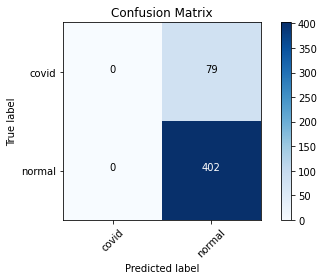

In [16]:
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


model.load_weights(weight_name)

y_predicted =  model.predict_classes(x_test)
#print(y_predicted)

#print(y_test)

y_true = np.argmax(y_test, axis=1)
#print(y_true)


from sklearn.metrics import confusion_matrix


classes=['covid', 'normal']


cm=confusion_matrix(y_true, y_predicted,labels=[0,1])

print(cm)
print("\n")





#plot confusion matrix




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):

    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plt.figure()
plot_confusion_matrix(cm, classes)


from sklearn.metrics import classification_report


print(classification_report(y_true, y_predicted))

No handles with labels found to put in legend.


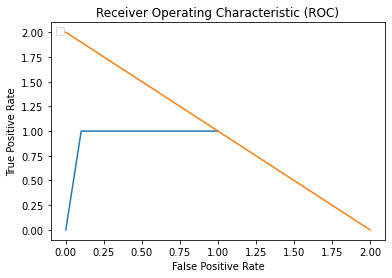

In [7]:
#Roc curve
from sklearn.metrics import roc_curve



import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
# y-expected output ve ypred_prediction

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_predicted)
roc_auc=auc(fpr_keras,tpr_keras)

plt.figure()
plt.plot(fpr_keras, tpr_keras,thresholds_keras)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")

plt.legend(loc='upper left')

plt.show()